<a href="https://colab.research.google.com/github/abishekparajuli-np/FaceEmotionDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [2]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [3]:
train = f"{path}/train"
test  = f"{path}/test"

In [4]:
image_size=48
batch_size=64
num_classes=7

In [5]:
emotions=['angry','disgust','fear','happy','neutral','sad','surprise']

In [6]:
def count_images(directory):
    counts={}
    for emotion in emotions:
        path = os.path.join(directory,emotion)
        if os.path.exists(path):
            counts[emotion]=len(os.listdir(path))
    return counts

In [7]:
train_counts=count_images(train)
test_counts=count_images(test)

In [8]:
train_counts

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [9]:
test_counts

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

In [10]:
#Test and Train Data Distribution Visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sna

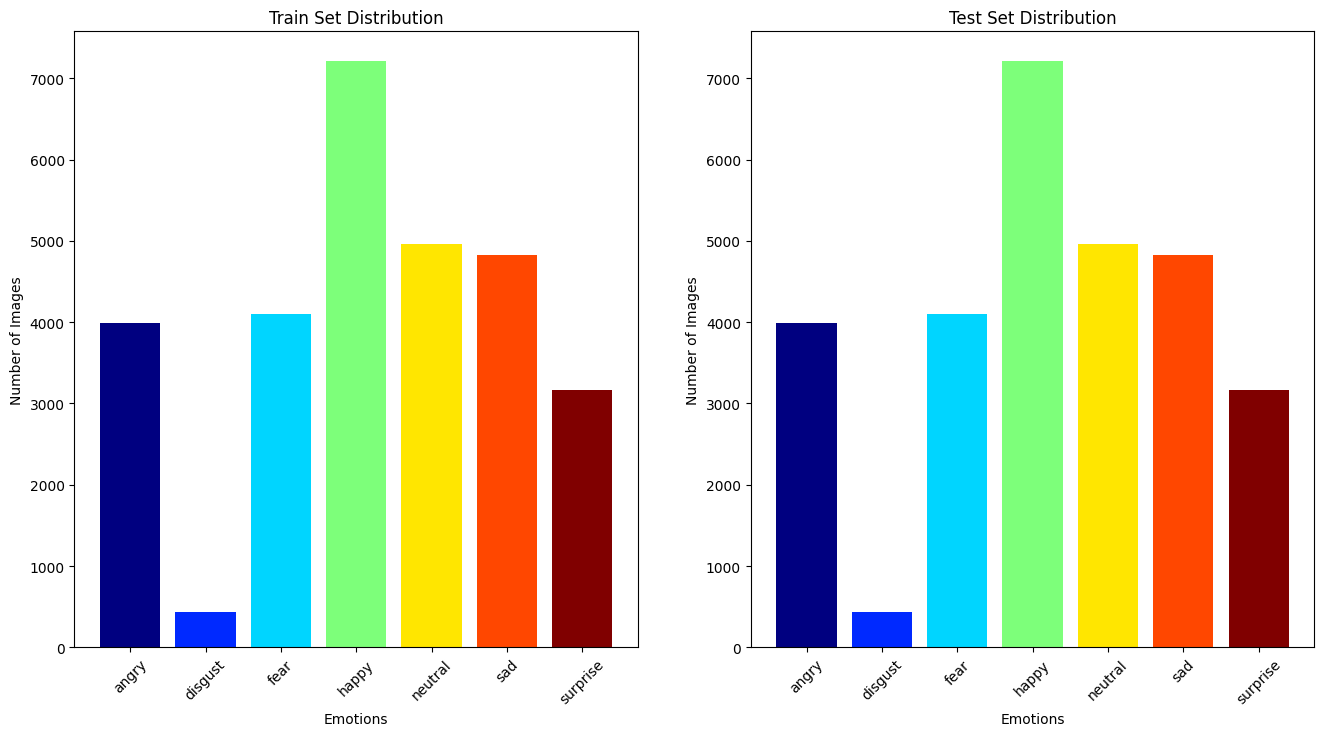

In [12]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
colors=plt.cm.jet(np.linspace(0,1,len(emotions)))

#train_set
ax1=axes[0]
bars1 = ax1.bar(train_counts.keys(),train_counts.values(),color=colors)
ax1.set_title("Train Set Distribution")
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x',rotation=45)

#test_set
ax2=axes[1]
bars2 = ax2.bar(train_counts.keys(),train_counts.values(),color=colors)
ax2.set_title("Test Set Distribution")
ax2.set_xlabel('Emotions')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x',rotation=45)


plt.show()

In [13]:
print('Most Samples={0}({1})'.format(max(train_counts,key=train_counts.get),max(train_counts.values())))
print('Least Samples={0}({1})'.format(min(train_counts,key=train_counts.get),min(train_counts.values())))

Most Samples=happy(7215)
Least Samples=disgust(436)


In [14]:
#Sample Image for eacg category

In [15]:
import cv2

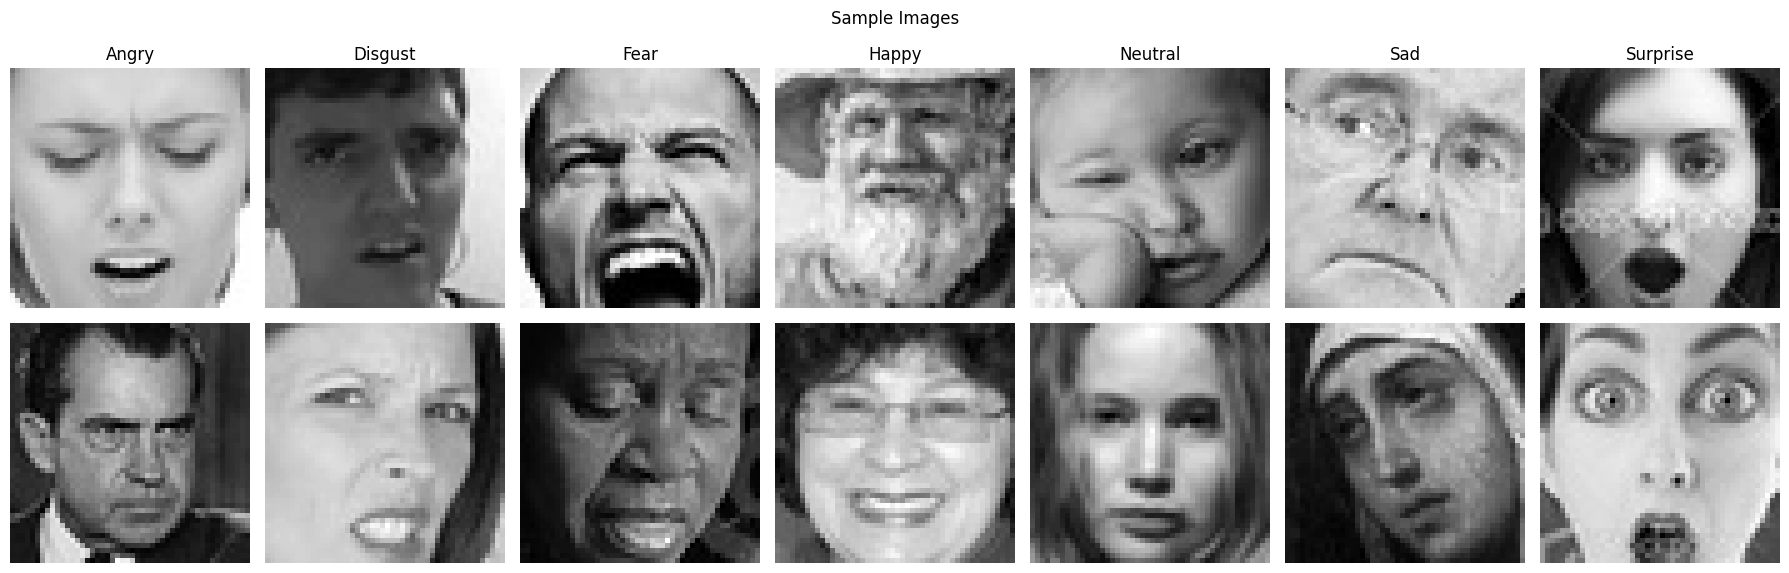

In [16]:
fig,axes=plt.subplots(2,7,figsize=(18,6))

for idx,emotion in enumerate(emotions):
    emotion_path=os.path.join(train,emotion)
    sample_images = os.listdir(emotion_path)[: 2]

    for row,imag_name in enumerate(sample_images):
        img_path=os.path.join(emotion_path, imag_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, idx].imshow(img, cmap='gray')
        axes[row,idx].axis('off')
        if row == 0:
            axes[row,idx].set_title(emotion.capitalize())

plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,           # Increased from 15
    width_shift_range=0.2,       # Increased from 0.15
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # NEW: brightness variation
    fill_mode='nearest',
    validation_split=0.15
)

test_data = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator=test_data.flow_from_directory(
    test,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [21]:
train_generator.samples

24406

In [22]:
validation_generator.samples

4303

In [23]:
test_generator.samples

7178

In [24]:
#Real and Augumented Image

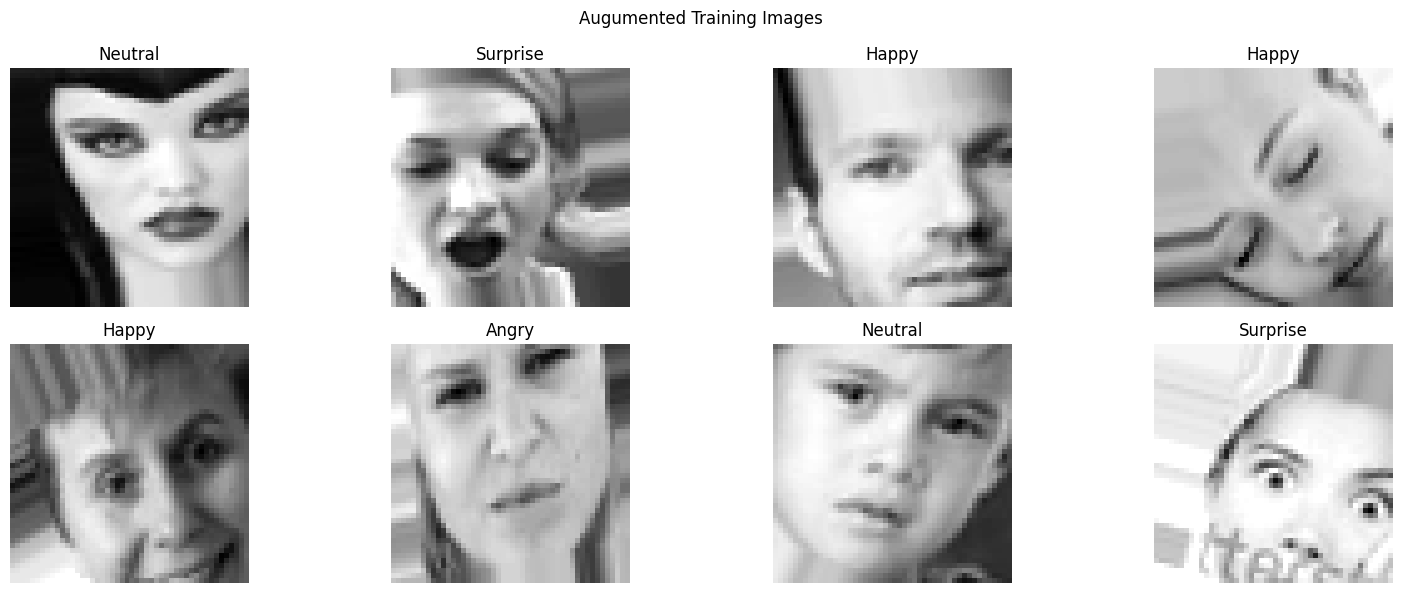

In [25]:
def visualize_augmentation(generator,num_images=8):
    batch_x, batch_y =next(generator)

    fig,axes=plt.subplots(2,num_images//2,figsize=(16,6))
    axes=axes.flatten()

    for i in range(num_images):
        axes[i].imshow(batch_x[i].reshape(image_size,image_size),cmap='gray')
        label_idx=np.argmax(batch_y[i])
        axes[i].set_title(emotions[label_idx].capitalize())
        axes[i].axis('off')

    plt.suptitle('Augumented Training Images')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)

In [26]:
#Handling Unbalanced Class

In [27]:
from sklearn.utils.class_weight import compute_class_weight

In [28]:
class_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

In [29]:
#Visualize Class Weight

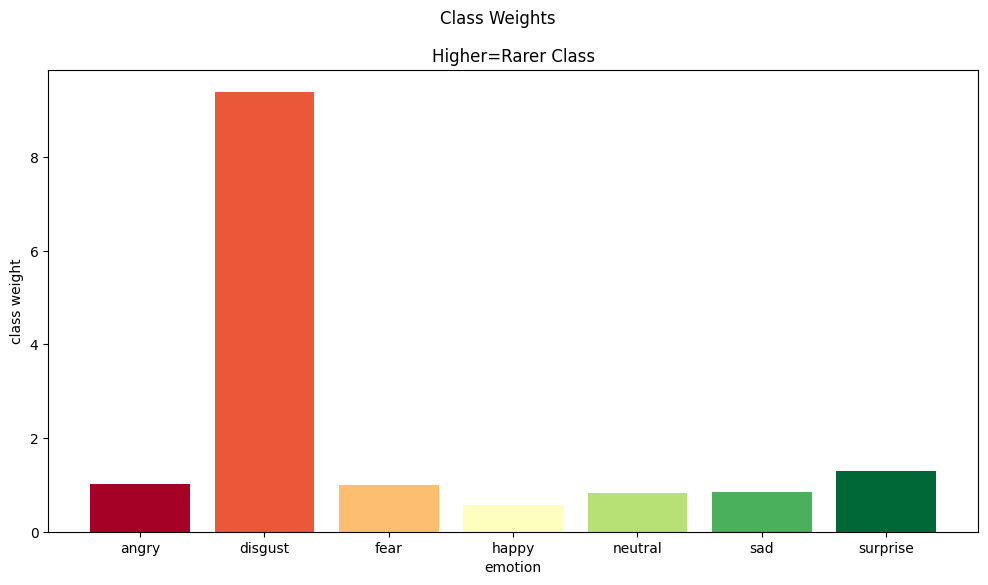

In [30]:
plt.figure(figsize=(12,6))
plt.bar(emotions,class_weights,color=plt.cm.RdYlGn(np.linspace(0,1,len(emotions))))
plt.suptitle('Class Weights')
plt.title('Higher=Rarer Class')
plt.xlabel('emotion')
plt.ylabel('class weight')
plt.show()

In [35]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
     Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D,Input, Activation, SpatialDropout2D,Add)
from tensorflow.keras.regularizers import l2

In [36]:
def build_emotion_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential(name='ImprovedEmotionCNN')

    # Block 1: Edge detection (64 filters)
    model.add(Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005),  # Reduced L2
                     input_shape=input_shape, name='conv1_1'))
    model.add(BatchNormalization(name='bn1_1'))
    model.add(Activation('relu', name='relu1_1'))
    model.add(Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv1_2'))
    model.add(BatchNormalization(name='bn1_2'))
    model.add(Activation('relu', name='relu1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(SpatialDropout2D(0.2, name='spatial_dropout1'))  # Changed to SpatialDropout2D

    # Block 2: Texture detection (128 filters)
    model.add(Conv2D(128, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv2_1'))
    model.add(BatchNormalization(name='bn2_1'))
    model.add(Activation('relu', name='relu2_1'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv2_2'))
    model.add(BatchNormalization(name='bn2_2'))
    model.add(Activation('relu', name='relu2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(SpatialDropout2D(0.25, name='spatial_dropout2'))

    # Block 3: Facial parts (256 filters)
    model.add(Conv2D(256, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv3_1'))
    model.add(BatchNormalization(name='bn3_1'))
    model.add(Activation('relu', name='relu3_1'))
    model.add(Conv2D(256, (3, 3), padding='same',  # Fixed kernel size
                     kernel_regularizer=l2(0.0005), name='conv3_2'))
    model.add(BatchNormalization(name='bn3_2'))
    model.add(Activation('relu', name='relu3_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(SpatialDropout2D(0.3, name='spatial_dropout3'))

    # Block 4: Expression patterns (512 filters)
    model.add(Conv2D(512, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv4_1'))
    model.add(BatchNormalization(name='bn4_1'))
    model.add(Activation('relu', name='relu4_1'))
    model.add(Conv2D(512, (3, 3), padding='same',
                     kernel_regularizer=l2(0.0005), name='conv4_2'))
    model.add(BatchNormalization(name='bn4_2'))
    model.add(Activation('relu', name='relu4_2'))

    # Global Average Pooling instead of MaxPooling for last layer
    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dropout(0.4, name='dropout_gap'))

    # Dense layers
    model.add(Dense(512, kernel_regularizer=l2(0.0005), name='fc1'))
    model.add(BatchNormalization(name='bn_fc1'))
    model.add(Activation('relu', name='relu_fc1'))
    model.add(Dropout(0.5, name='dropout_fc1'))

    model.add(Dense(256, kernel_regularizer=l2(0.0005), name='fc2'))
    model.add(BatchNormalization(name='bn_fc2'))
    model.add(Activation('relu', name='relu_fc2'))
    model.add(Dropout(0.5, name='dropout_fc2'))

    # Output layer with label smoothing built into loss
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [37]:
model=build_emotion_cnn()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "ImprovedEmotionCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1                │ (None, 24, 24, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2                │ (None, 12, 12, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3                │ (None, 6, 6, 256)      │             

 Total params: 5,090,759 (19.42 MB)

 Trainable params: 5,085,383 (19.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [39]:
from tensorflow.keras.optimizers import Adam,SGD

In [40]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower initial LR
    loss=CategoricalCrossentropy(label_smoothing=0.1),  # Label smoothing
    metrics=['accuracy']
)

In [42]:
model.count_params()

5090759

In [43]:
from tensorflow.keras. callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)

In [44]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Increased patience
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        filepath='best_emotion_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        write_graph=True
    )
]

In [45]:
steps_per_epoch=train_generator.samples // batch_size
validation_step = validation_generator.samples // batch_size

In [46]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Handle imbalance
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.1398 - loss: 3.5606
Epoch 1: val_accuracy improved from -inf to 0.01511, saving model to best_emotion_model.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 190s 437ms/step - accuracy: 0.1398 - loss: 3.5603 - val_accuracy: 0.0151 - val_loss: 3.1641 - learning_rate: 5.0000e-04
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1474 - loss: 3.1737
Epoch 2: val_accuracy improved from 0.01511 to 0.15756, saving model to best_emotion_model.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.1474 - loss: 3.1736 - val_accuracy: 0.1576 - val_loss: 2.9066 - learning_rate: 5.0000e-04
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1550 - loss: 2.9568
Epoch 3: val_accuracy did not improve from 0.15756
382/382 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.1550 - loss: 2.9566 - val_accuracy: 0.1322 - val_loss: 2.7219 - learning_rate: 5.0000e-04
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 10

In [ ]:
#Visualising Training Metrics

In [47]:
def plot_training_history(history):
  fig, axes= plt.subplots(1,2,figsize=(12,6))

  ax1=axes[0]
  ax1.plot(history.history['accuracy'],label='Training Accuracy',linewidth=2)
  ax1.plot(history.history['val_accuracy'],label='Validation Accuracy',linewidth=2)
  ax1.set_title('Model Accuracy Over Epcohs')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc='lower right')
  ax1.grid(True)

  best_val_acc=max(history.history['val_accuracy'])
  best_epoch=history.history['val_accuracy'].index(best_val_acc)
  print("{0},{1}".format(best_val_acc,best_epoch))
  ax2=axes[1]
  ax2.plot(history.history['loss'],label='Training Loss',linewidth=2)
  ax2.plot(history.history['val_loss'],label='Validation Loss',linewidth=2)
  ax2.set_title('Model Loss Over Epochs')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend(loc='upper right')
  ax2.grid(True)

  best_val_loss = min(history.history['val_loss'])
  best_loss_epoch=history.history['val_loss'].index(best_val_loss)
  print("{0},{1}".format(best_val_loss,best_loss_epoch))

  plt.tight_layout()
  plt.show()

0.5863351225852966,96
1.4319136142730713,96


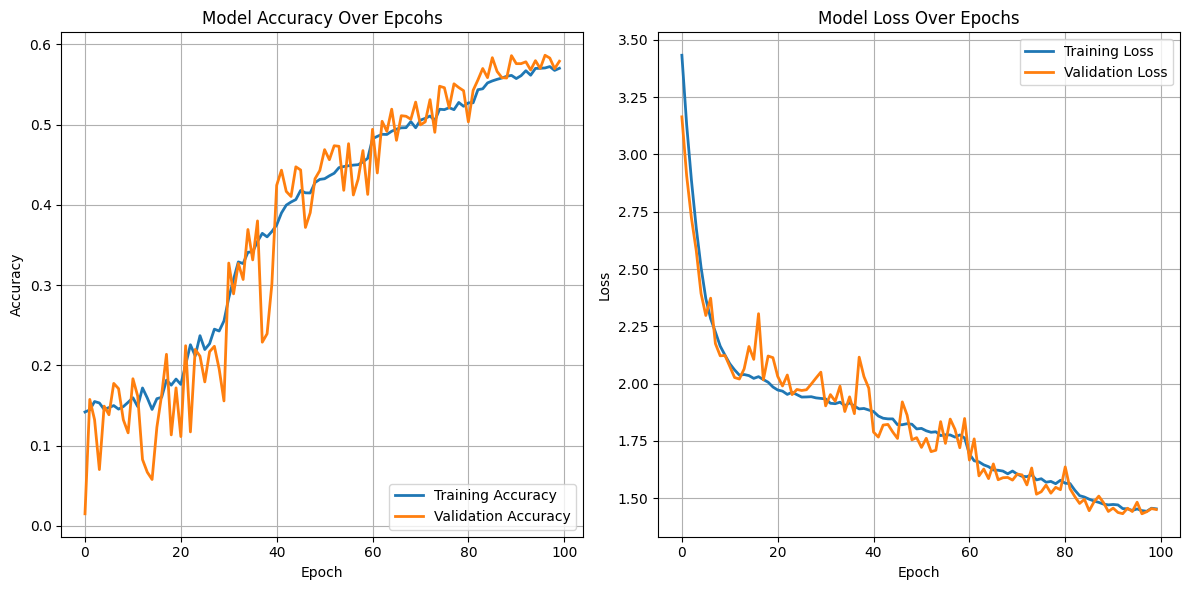

In [48]:
plot_training_history(history)

In [49]:
from tensorflow.keras.models import load_model

In [50]:
best_model=load_model('best_emotion_model.keras')
print('Ealuating On Test Set')
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

Ealuating On Test Set
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 334ms/step - accuracy: 0.5827 - loss: 1.4172


In [51]:
test_loss

1.3721004724502563

In [52]:
test_accuracy

0.6182780861854553

In [53]:
from sklearn.metrics import classification_report

In [54]:
test_generator.reset()
y_pred_probs= best_model.predict(test_generator, verbose=1)
y_pred=np.argmax(y_pred_probs, axis=1)
y_true= test_generator.classes

report=classification_report(y_true,y_pred, target_names=[e for e in emotions],digits=4)
print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step
              precision    recall  f1-score   support

       angry     0.5157    0.5825    0.5471       958
     disgust     0.2635    0.7027    0.3833       111
        fear     0.4691    0.2598    0.3344      1024
       happy     0.8423    0.8613    0.8517      1774
     neutral     0.5752    0.6139    0.5940      1233
         sad     0.4936    0.4956    0.4946      1247
    surprise     0.7438    0.7617    0.7527       831

    accuracy                         0.6183      7178
   macro avg     0.5576    0.6111    0.5654      7178
weighted avg     0.6187    0.6183    0.6122      7178



In [55]:
#confusion_matrix

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [57]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Counts
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes, yticklabels=classes,
        ax=axes[0]
    )
    axes[0].set_title('Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Percent annotations
    annot_percent = np.array([[f"{v*100:.2f}%" for v in row] for row in cm_normalized])

    sns.heatmap(
        cm_normalized, annot=annot_percent, fmt='', cmap='RdYlGn',
        xticklabels=classes, yticklabels=classes,
        ax=axes[1]
    )
    axes[1].set_title('Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


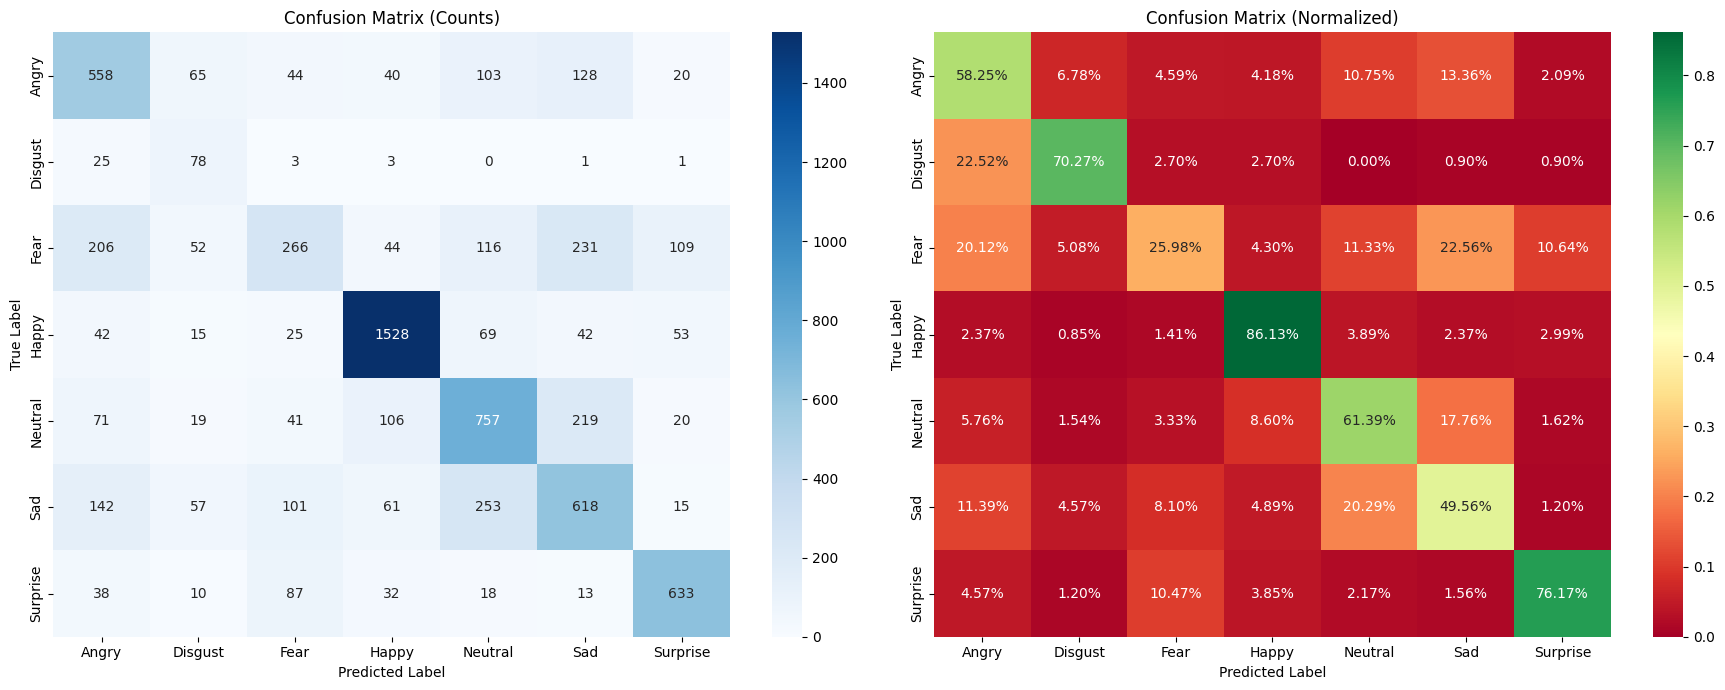

In [58]:
plot_confusion_matrix(y_true, y_pred, [e.capitalize() for e in emotions])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


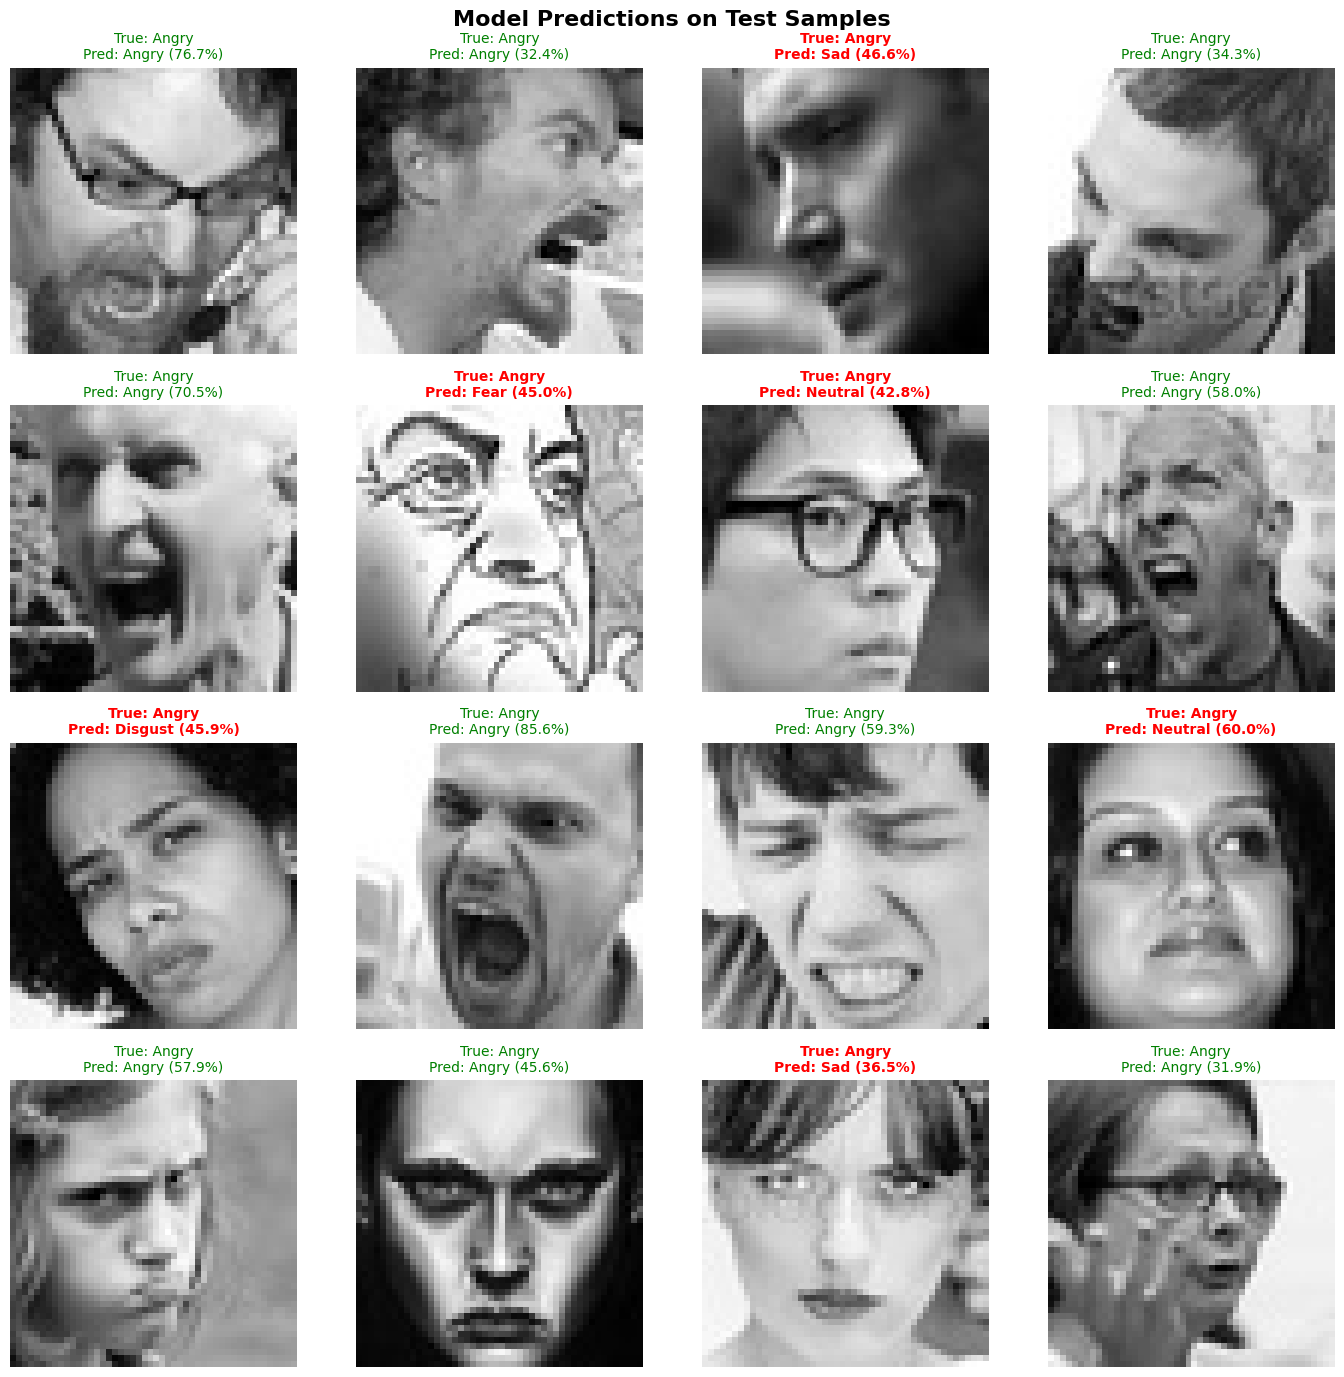

In [59]:
def visualize_predictions(model, test_generator, num_samples=16):


    test_generator.reset()
    batch_x, batch_y = next(test_generator)
    predictions = model.predict(batch_x)

    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()

    for i in range(min(num_samples, len(batch_x))):
        img = batch_x[i].reshape(image_size, image_size)
        true_label = emotions[np.argmax(batch_y[i])].capitalize()
        pred_label = emotions[np.argmax(predictions[i])].capitalize()
        confidence = np.max(predictions[i]) * 100

        correct = true_label == pred_label
        color = 'green' if correct else 'red'

        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(
            f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
            fontsize=10,
            color=color,
            fontweight='bold' if not correct else 'normal'
        )

    plt.suptitle('Model Predictions on Test Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150)
    plt.show()

visualize_predictions(best_model, test_generator)

In [60]:
model.save("emotion_model.keras")

In [61]:
from google.colab import files
files.download("emotion_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>